In [14]:
import dill as pickle
from cosinorage.datahandlers import NHANESDataHandler, plot_enmo
from cosinorage.features import WearableFeatures, dashboard
from cosinorage.bioages import CosinorAge

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
reload_nhanes = False

In [16]:
if reload_nhanes:
    nhanes_handler = NHANESDataHandler(nhanes_file_dir='../data/nhanes/', seqn=62177, verbose=True)
    with open("pickle/nhanes_handler.pkl", "wb") as file:
        pickle.dump(nhanes_handler, file)
else:
    with open("pickle/nhanes_handler.pkl", "rb") as file:
        nhanes_handler = pickle.load(file)

In [17]:
nhanes_handler.get_meta_data()

{'datasource': 'nhanes',
 'raw_n_datapoints': 10080,
 'raw_start_datetime': Timestamp('1900-01-02 00:00:00'),
 'raw_end_datetime': Timestamp('1900-01-08 23:59:00'),
 'raw_data_frequency': 'minute-level',
 'raw_data_type': 'accelerometer',
 'raw_data_unit': 'MIMS',
 'n_days': 7}

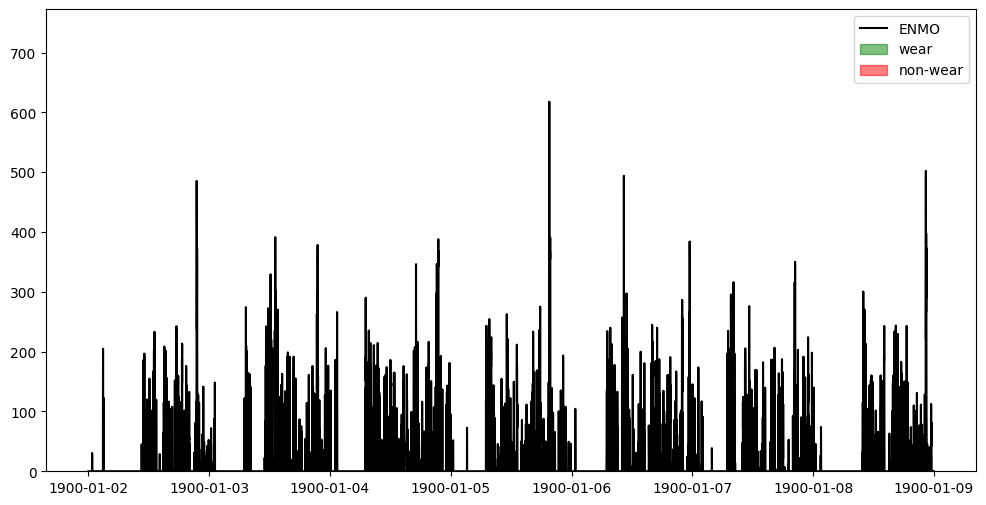

In [18]:
plot_enmo(nhanes_handler)

In [19]:
features_args = {
    'sleep_ck_sf': 0.0025,
    'sleep_rescore': True,
    'pa_cutpoint_sl': 15,
    'pa_cutpoint_lm': 70,
    'pa_cutpoint_mv': 130,
}

In [20]:
features = WearableFeatures(nhanes_handler, features_args)

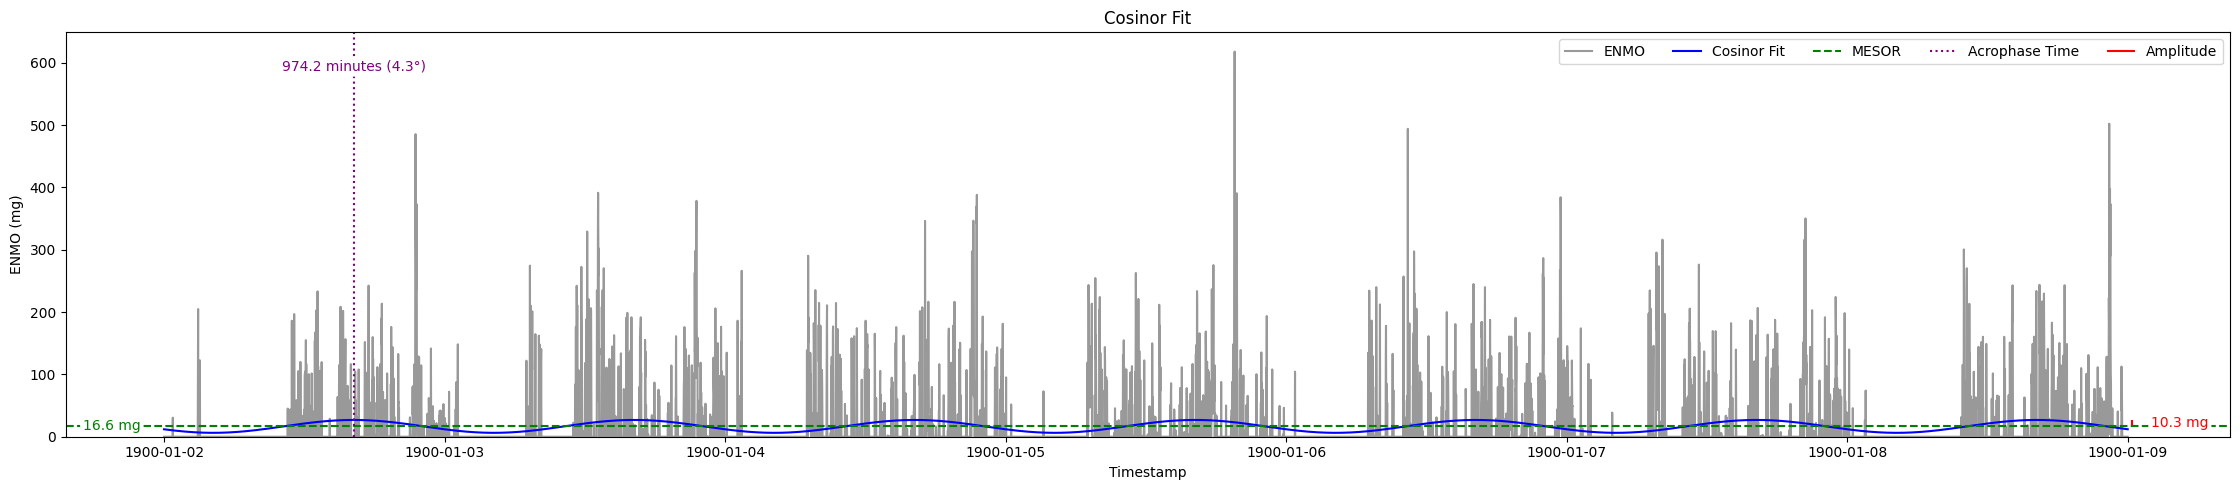

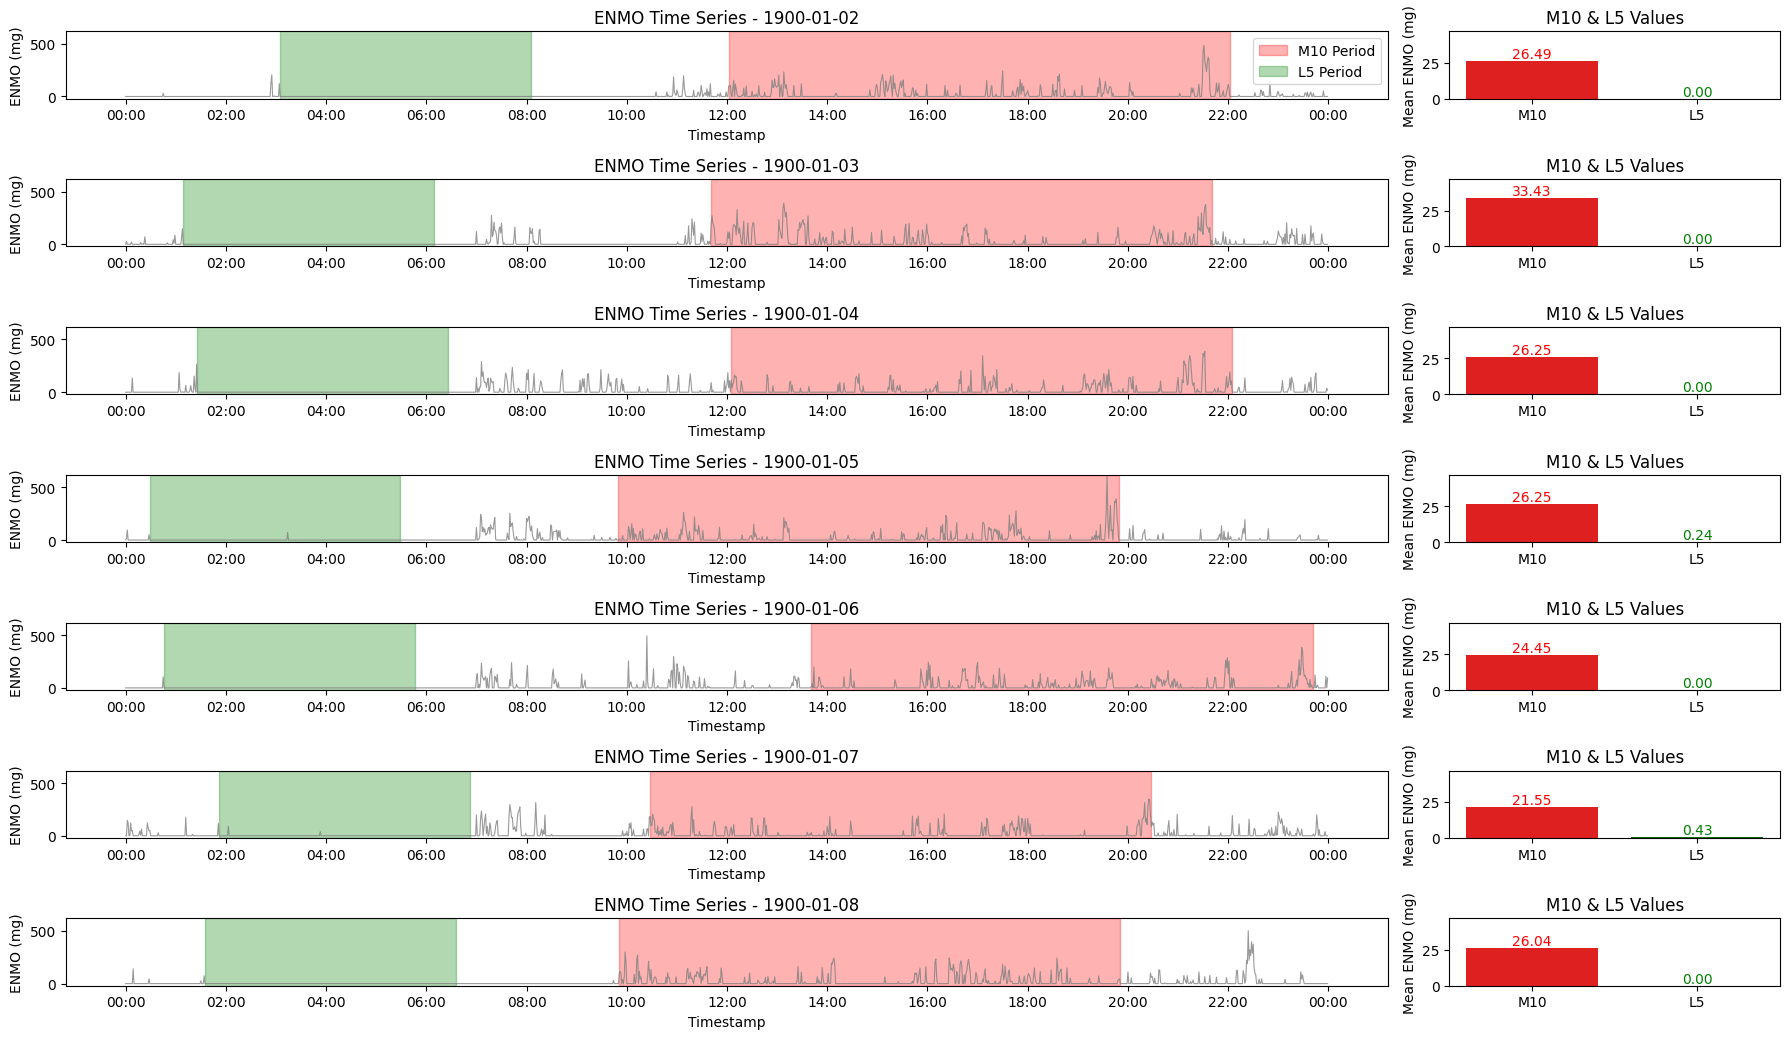

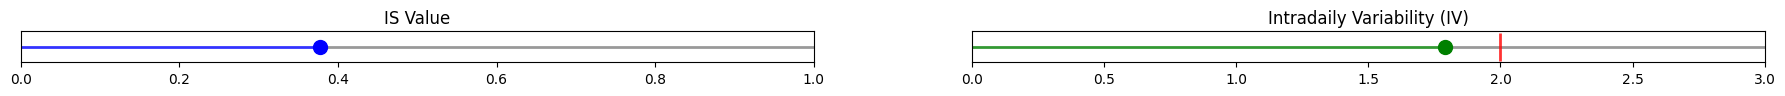

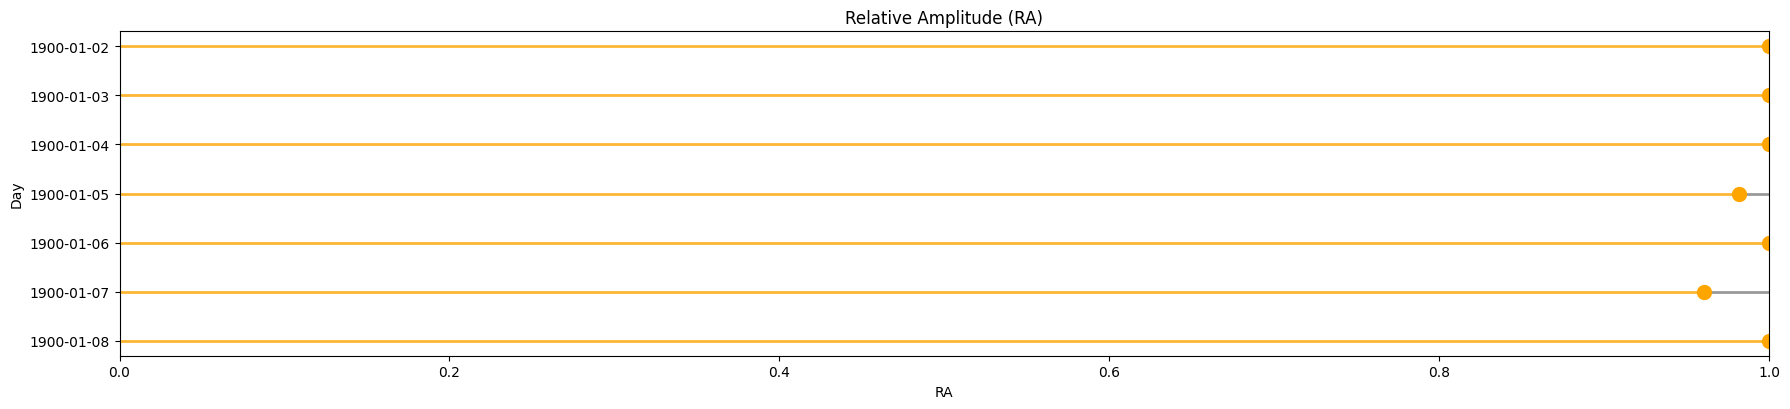

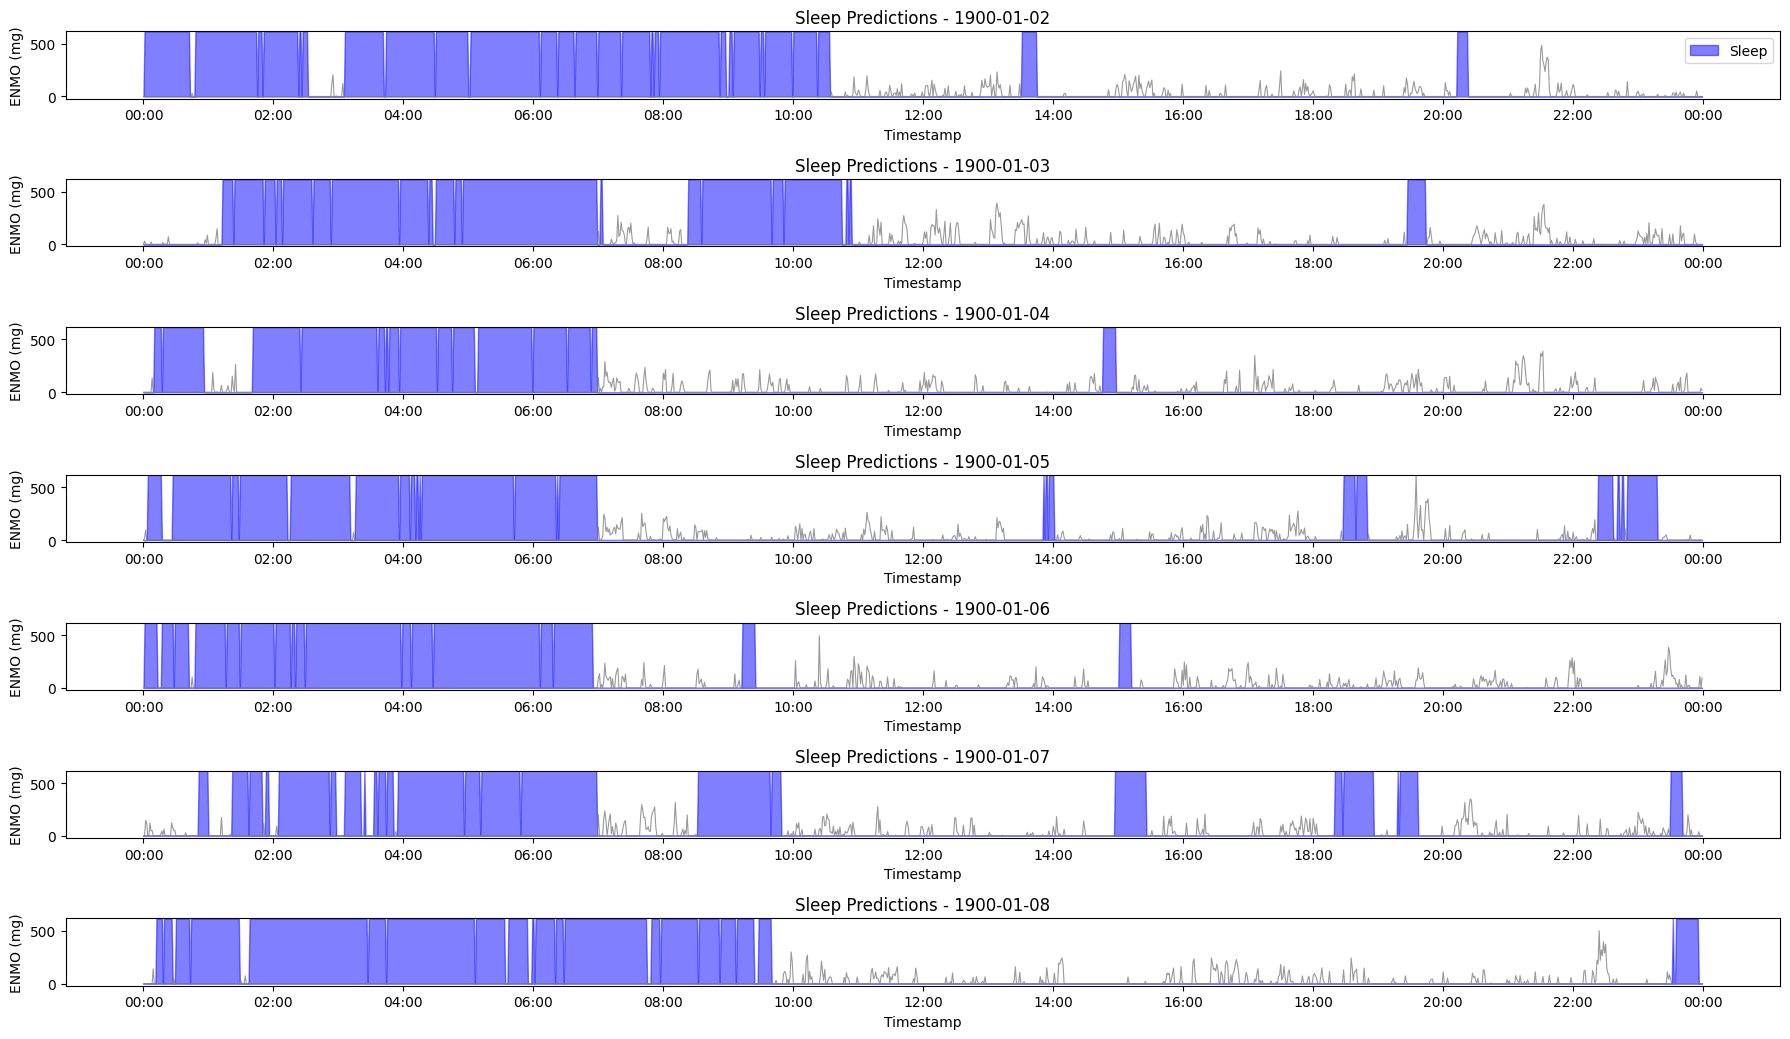

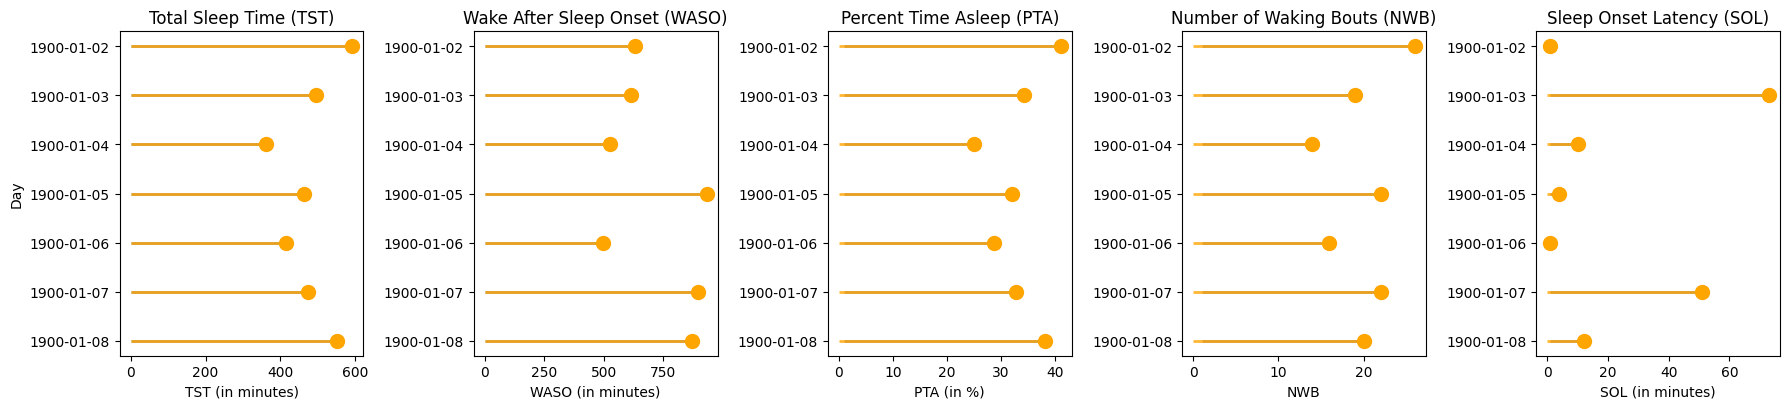

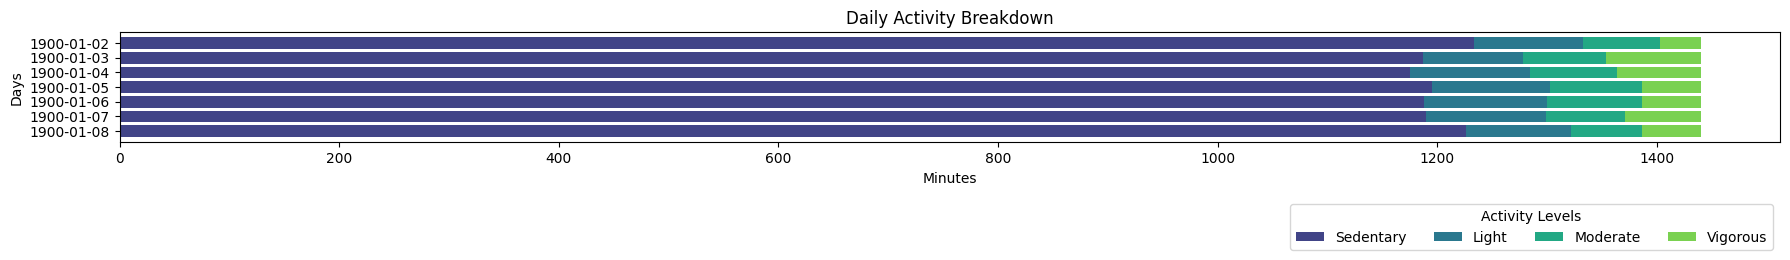

In [21]:
dashboard(features)

In [22]:
import pandas as pd
def get_chrono_age_and_gender(file_path, seqn):
    data = pd.read_csv(file_path)
    data = data[data['seqn'] == seqn]
    age = data['age'].values[0]
    if data['sex'].values[0] == 'Male':
        gender = 'male'
    elif data['sex'].values[0] == 'Female':
        gender = 'female'
    else:
        gender = 'unknown'
    return int(age), gender

In [23]:
records = [
    {'handler': nhanes_handler, 
     'age': get_chrono_age_and_gender('../data/Age_sex_data/nhanes_age_sex.csv', 62177)[0], 
     'gender': get_chrono_age_and_gender('../data/Age_sex_data/nhanes_age_sex.csv', 62177)[1]    
    }
]

KeyError: 'gender'

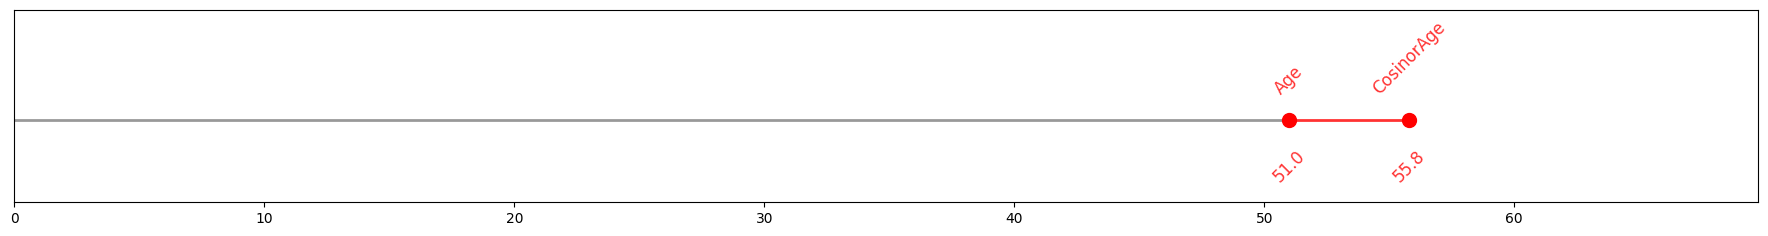

In [13]:
cosinor_age = CosinorAge(records)
cosinor_age.plot_predictions()